Reference: https://github.com/twitterdev/do_more_with_twitter_data/blob/master/examples/timeseries/timeseries.ipynb

In [103]:
import datetime
import functools
import itertools
from pathlib import Path
from timeit import default_timer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer

from utils import *
from topic_utils import *

In [2]:
%matplotlib notebook
plt.style.use("bmh")

pd.options.display.float_format = '{:.2f}'.format

# Timeseries

In [3]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')

In [5]:
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]
campaign = df[df['campaign'] == 'iran202012']
campaign_users = user_df[user_df['campaign'] == 'iran202012']

In [7]:
campaign_start = min(campaign['tweet_time'])
campaign_end = max(campaign['tweet_time'])
campaign_period = campaign_end - campaign_start

print(campaign_start)
print(campaign_end)
print(campaign_period)

2009-09-06 13:56:00
2020-12-27 18:08:00
4130 days 04:12:00


In [8]:
campaign_years = campaign_period / np.timedelta64(1, "Y")
campaign_years

11.30803507258876

In [9]:
def resample_ts(df, freq):
    return (df
             .set_index('tweet_time')
             .resample(freq)
             .size()
             .reset_index()
             .rename(columns={0:'per_{}_count'.format(freq)})
             .set_index('tweet_time')
            )

In [40]:
hourly

,per_H_count
tweet_time,
2009-07-06 06:00:00,2
2009-07-06 07:00:00,0
2009-07-06 08:00:00,0
2009-07-06 09:00:00,1
2009-07-06 10:00:00,0
...,...
2020-12-27 18:00:00,5
2020-12-27 19:00:00,0
2020-12-27 20:00:00,0


<IPython.core.display.Javascript object>


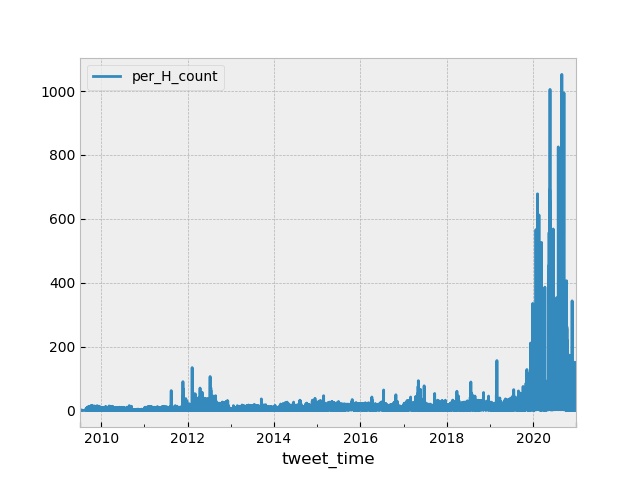

In [10]:
hourly = resample_ts(df, 'H')
hourly.plot()

<IPython.core.display.Javascript object>


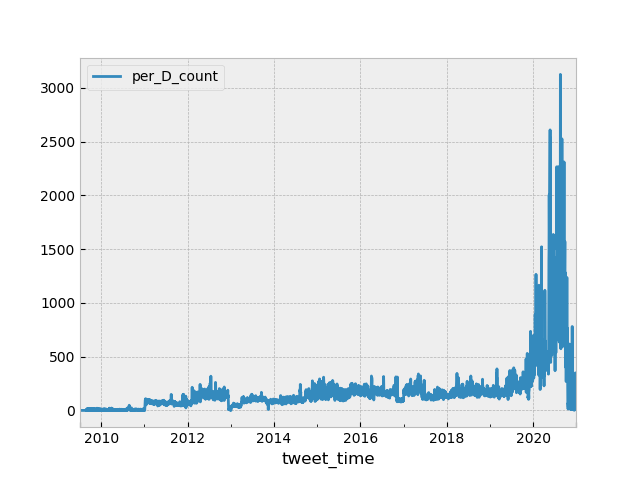

In [11]:
daily = resample_ts(df, 'D')
daily.plot()

In [12]:
print('hourly tweets:\n{}'.format(hourly
                                 .describe()
                                 .astype('int')
                                )
     )

hourly tweets:
       per_H_count
count       100625
mean             7
std             17
min              0
25%              2
50%              4
75%              8
max           1052


<IPython.core.display.Javascript object>


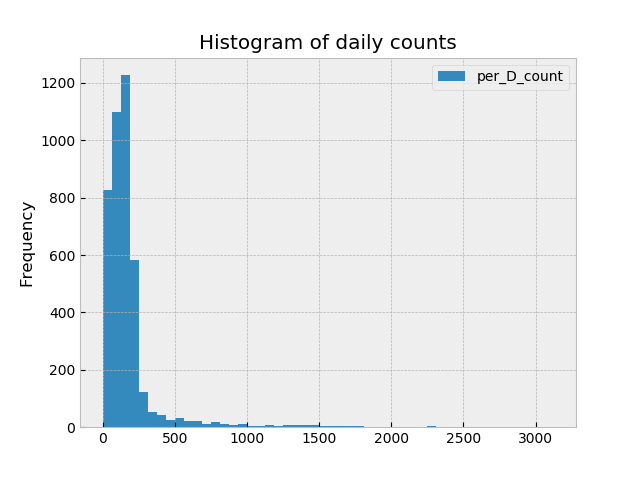

In [14]:
(daily
 .plot.hist(bins=50, title="Histogram of daily counts")
)

The histogram shows that most days in the duration of the campaign had a volume lower than about 250 tweets.

## Differencing

We can use simple differencing to get a sense of the change in tweet volume from day to day during the measured time period. This provides a measure of the variability in activity during parts of the campaign. We see that 

In [22]:
def standardize(df):
    return (df - df.mean()) / df.std()

In [23]:
daily_diff = (daily
             .diff()
             )
daily_std_diff = (daily
             .pipe(standardize)
             .diff()
            )

In [24]:
print(daily_diff
      .describe()
      .loc[['mean','std','min','max']]
)
print('\nstandardized:\n',
        daily_std_diff
         .describe()
         .loc[['min','max']]
)

      per_D_count
mean         0.01
std        117.46
min      -1980.00
max       1836.00

standardized:
      per_D_count
min        -8.33
max         7.72


<IPython.core.display.Javascript object>


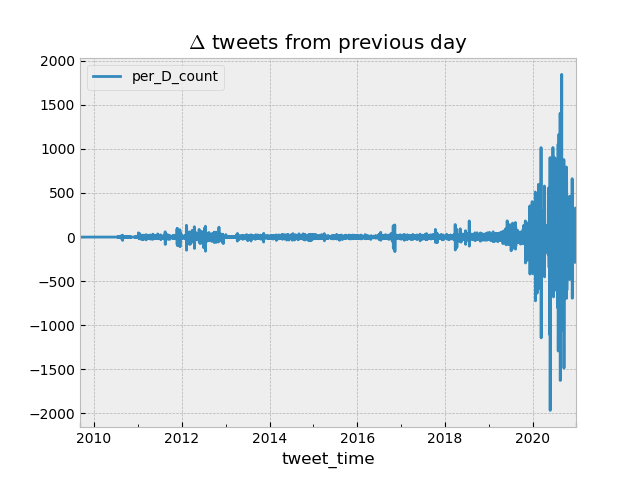

In [21]:
daily_diff.plot(title="$\Delta$ tweets from previous day")

In [23]:
hourly_diff = (hourly
              .diff()
              )

hourly_std_diff = (hourly
                     .pipe(standardize)
                     .diff()
                    )

<IPython.core.display.Javascript object>


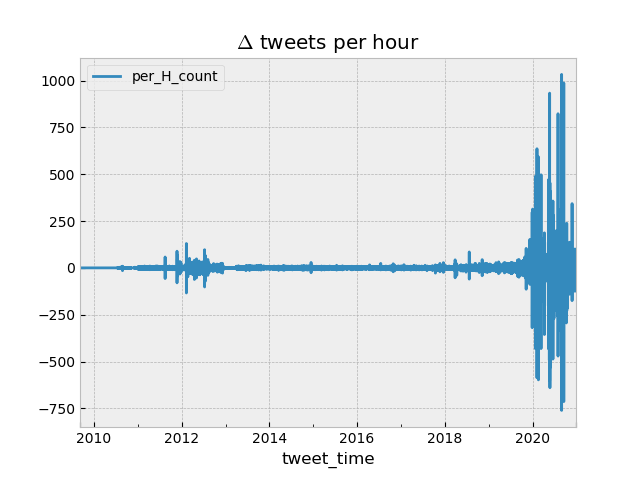

In [24]:
hourly_diff.plot(title="$\Delta$ tweets per hour")

<IPython.core.display.Javascript object>


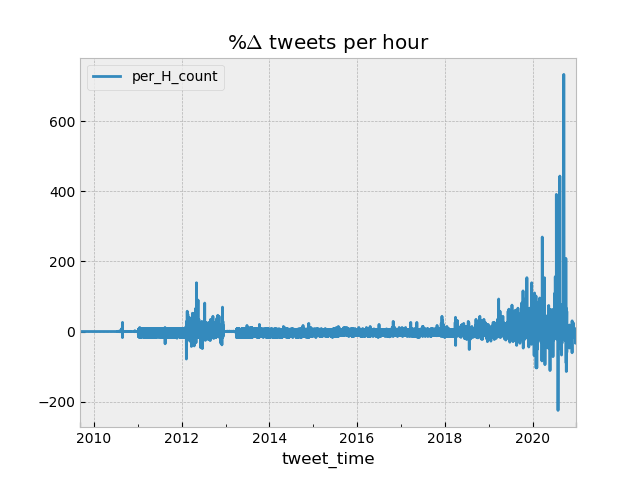

In [25]:
(hourly
 .pipe(standardize)
 .pct_change()
).plot(title="%$\Delta$ tweets per hour")

## Rolling statistics

Rolling statistics can be used to smooth out the signal and show trends more clearly.

<IPython.core.display.Javascript object>


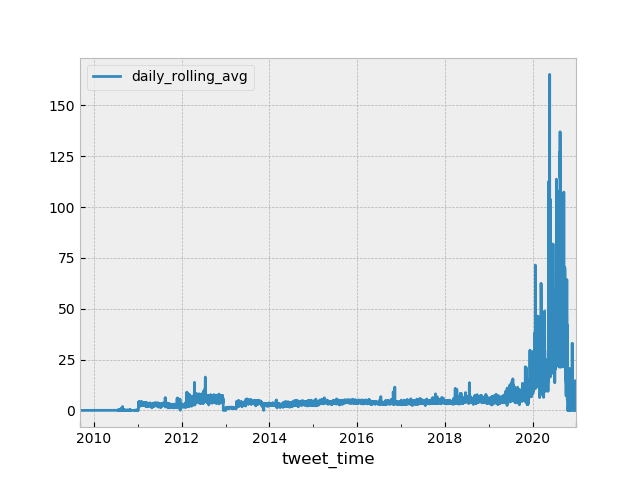

In [51]:
(hourly
 .rolling(24)
 .mean()
 .rename(columns={'per_H_count':'daily_rolling_avg',
                  'tweet_time':'time'})
 .fillna(0)
).plot()

In [ ]:
def plot_rolling(timeseries, columns):
    (hourly
     .rolling(24)
     .mean()
     .rename(columns={'per_H_count': 'daily moving average'})
     .plot(ax=axes, lw=0.9))

<IPython.core.display.Javascript object>


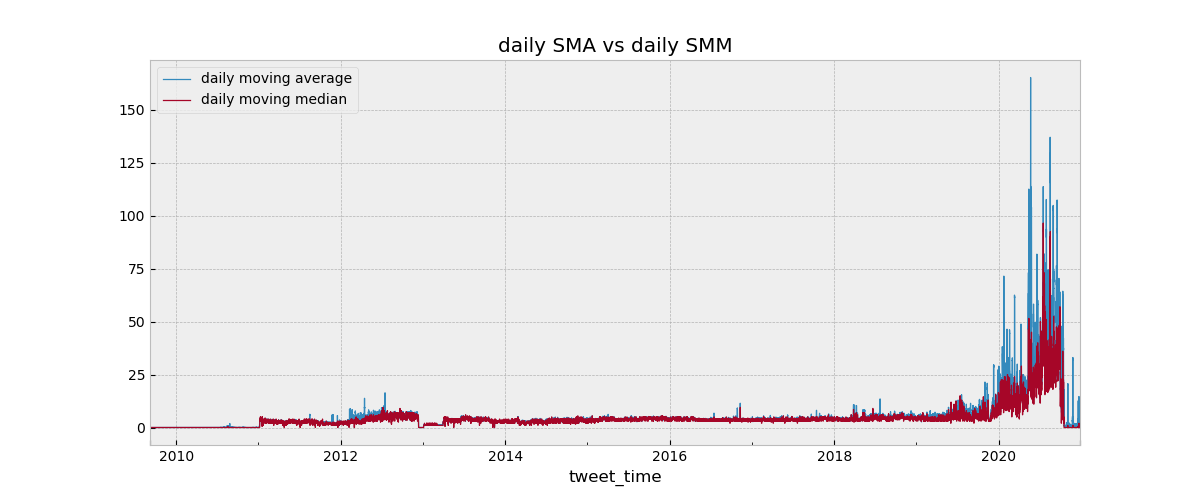

In [49]:
timeseries = [hourly, hourly]
labels = [{'per_H_count': 'daily moving average'},
          

fig, axes = plt.subplots(1,1,figsize=(12, 5))

(hourly
 .rolling(24)
 .mean()
 .rename(columns={'per_H_count': 'daily moving average'})
 .plot(ax=axes, lw=0.9))

(hourly
 .rolling(24)
 .median()
 .rename(columns={'per_H_count': 'daily moving median'})
 .plot(ax=axes, lw=0.9))

axes.set_title(label="daily SMA vs daily SMM");

The median is more robust than the mean to outlier values, which also helps us see a smoother signal and more general trend.

<IPython.core.display.Javascript object>


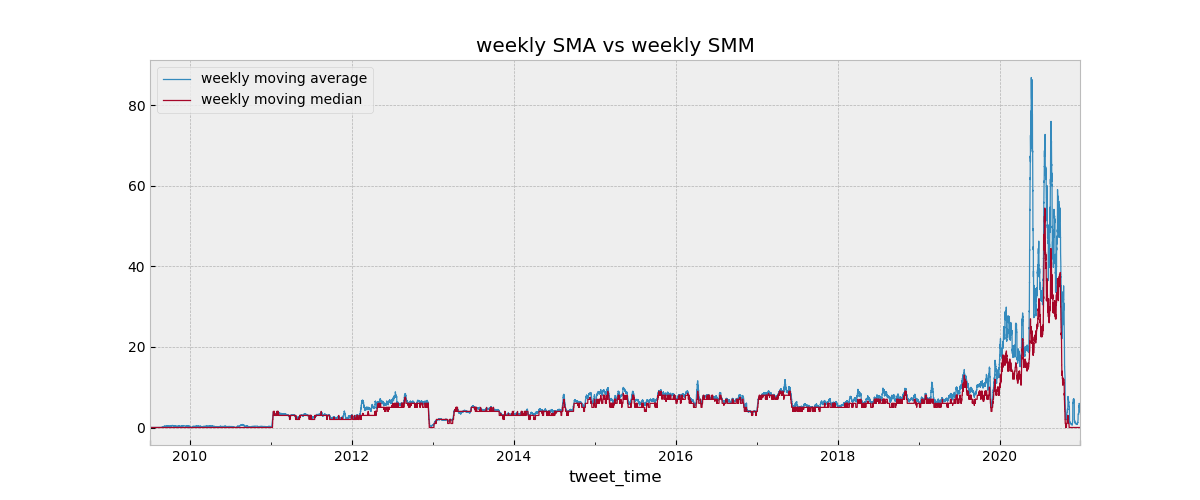

In [25]:
fig, axes = plt.subplots(1,1,figsize=(12, 5))

(hourly
 .rolling(24*7)
 .mean()
 .rename(columns={'per_H_count': 'weekly moving average'})
 .plot(ax=axes, lw=0.9));

(hourly
 .rolling(24*7)
 .median()
 .rename(columns={'per_H_count': 'weekly moving median'})
 .plot(ax=axes, lw=0.9));

axes.set_title(label="weekly SMA vs weekly SMM");

<IPython.core.display.Javascript object>


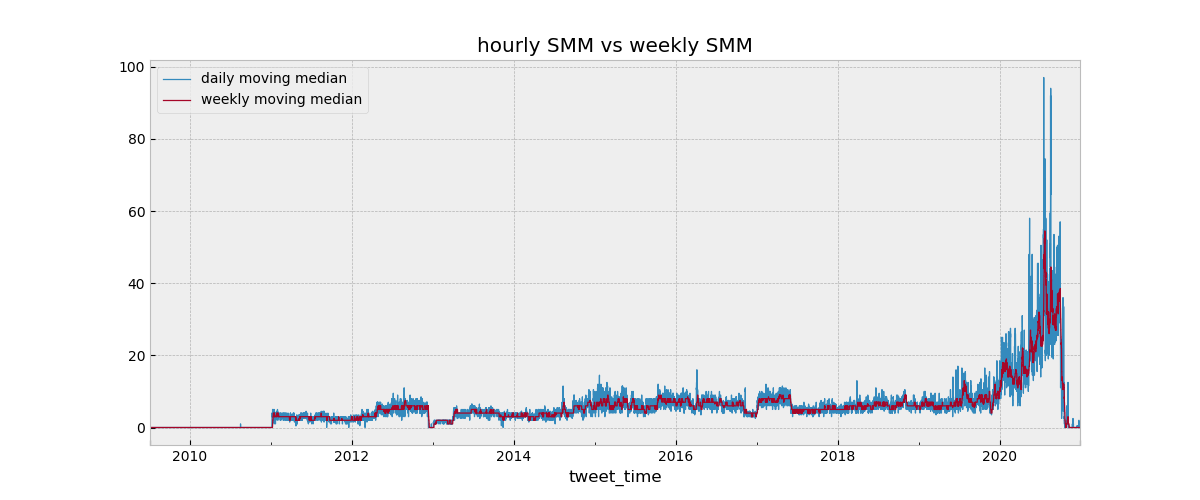

In [26]:
fig, axes = plt.subplots(1,1,figsize=(12, 5))

(hourly
 .rolling(24)
 .median()
 .rename(columns={'per_H_count': 'daily moving median'})
 .plot(ax=axes, lw=0.9));

(hourly
 .rolling(24*7)
 .median()
 .rename(columns={'per_H_count': 'weekly moving median'})
 .plot(ax=axes, lw=0.9));

axes.set_title(label="hourly SMM vs weekly SMM");

Here we observe the difference between time periods used for computing the rolling statistic.

## Time period
These initial views show a clear increase in tweet volume after 2019. Further analysis could for instance compare properties of tweets before 2019 with tweets after 2019. It appears that the campaign was more active in the latter period, so separating the two could show the difference between the active component of the campaign, and the earlier low-volumes activity.

We can also look at high-volume days of the campaign:

In [37]:
(daily
 .dropna()
 .sort_values(by='per_D_count',
              ascending=False)
).head()

,per_D_count
tweet_time,
2020-08-17,3124
2020-05-22,2608
2020-05-25,2533
2020-08-30,2525
2020-09-17,2310


In [79]:
top_day = (daily
             .dropna()
             .sort_values(by='per_D_count',
                          ascending=False)
            ).idxmax()

In [80]:
top_day

per_D_count   2020-08-17
dtype: datetime64[ns]

In [87]:
period = pd.date_range(top_day.iloc[0], periods=24*60*60, freq='s')

In [91]:
day = campaign['tweet_time'].isin(period)
(campaign
 .loc[day]['tweet_text']
)

tweetid
1295178029778366465    We strongly  believe  that what you aimed at i...
1295171150172102656    UAE has encouraged  the Zionist  regime to go ...
1295167588931076099    UAE couldn't  support  the master of terrorism...
1295171990119051264    UAE membuktikan bahwa mereka pengecut dengan b...
1295174953562787849    Imarati should end all its secret and public s...
                                             ...                        
1295155883807145984    Indonesia merdeka harus menjadi tujuan hidup k...
1295155884545302528    Hari kemerdekaan Indonesia adalah 17 Agustus s...
1295344560260952065    El presidente de la Federación Rusa, #Vladimir...
1295464601849602050    watch this !  Miles Taylor endorsing Biden! 
e...
1295463407651557378    Además de la pandemia y el caos político, Bras...
Name: tweet_text, Length: 3061, dtype: string

### Topic modeling for top day

In [135]:
string_agg = lambda x: list(x)
user_tweets = (campaign
               .loc[day]['tweet_text']
              )

In [143]:
tokens = preprocess_string(
            long_string(user_tweets))

In [144]:
tokens

"we strongly  believe  that what you aimed at it will not work out\n<-#-> uae has encouraged  the zionist  regime to go ahead in its annexation plan <-#-> uae couldn't  suppo  the master of terrorism  <-#-> uae membuktikan bahwa mereka pengecut dengan berdamai dengan israel\n<-#-> imarati should end all its secret and public suppo  to the zionist regime <-#-> angry libyans set fire to the uae embassy in tripoli in protest of the uae recent decision to normalize relations with the israeli zionist regime <-#-> <-#-> <-URL-> putra mahkota abu dhabi penguasa de facto uni emirat arab uea mengumumkan bahwa negaranya dan israel sepakat untuk menjalin hubungan bilateral <-#-> sea este hombre  incluso si su voz flaquea sus piernas tiemblan o sus músculos arden\nel hombre egipcio se enfrenta a los paidarios de la ocupación pro-israelí\n<-#-> <-#-> <-#-> <-URL-> un suv noir vient de se garer à l'arrière du centre de justice et de nombreux officiers du shérif armés en sont sois\n<-URL-> besok mutu

/home/sarah/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'url', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳол', 'ҳолате', 'әттеген', 'ӯим', 'अक', 'अग', 'अझ', 'अन', 'अर', 'आ

n_samples: 2000
n_features: 1000


<IPython.core.display.Javascript object>


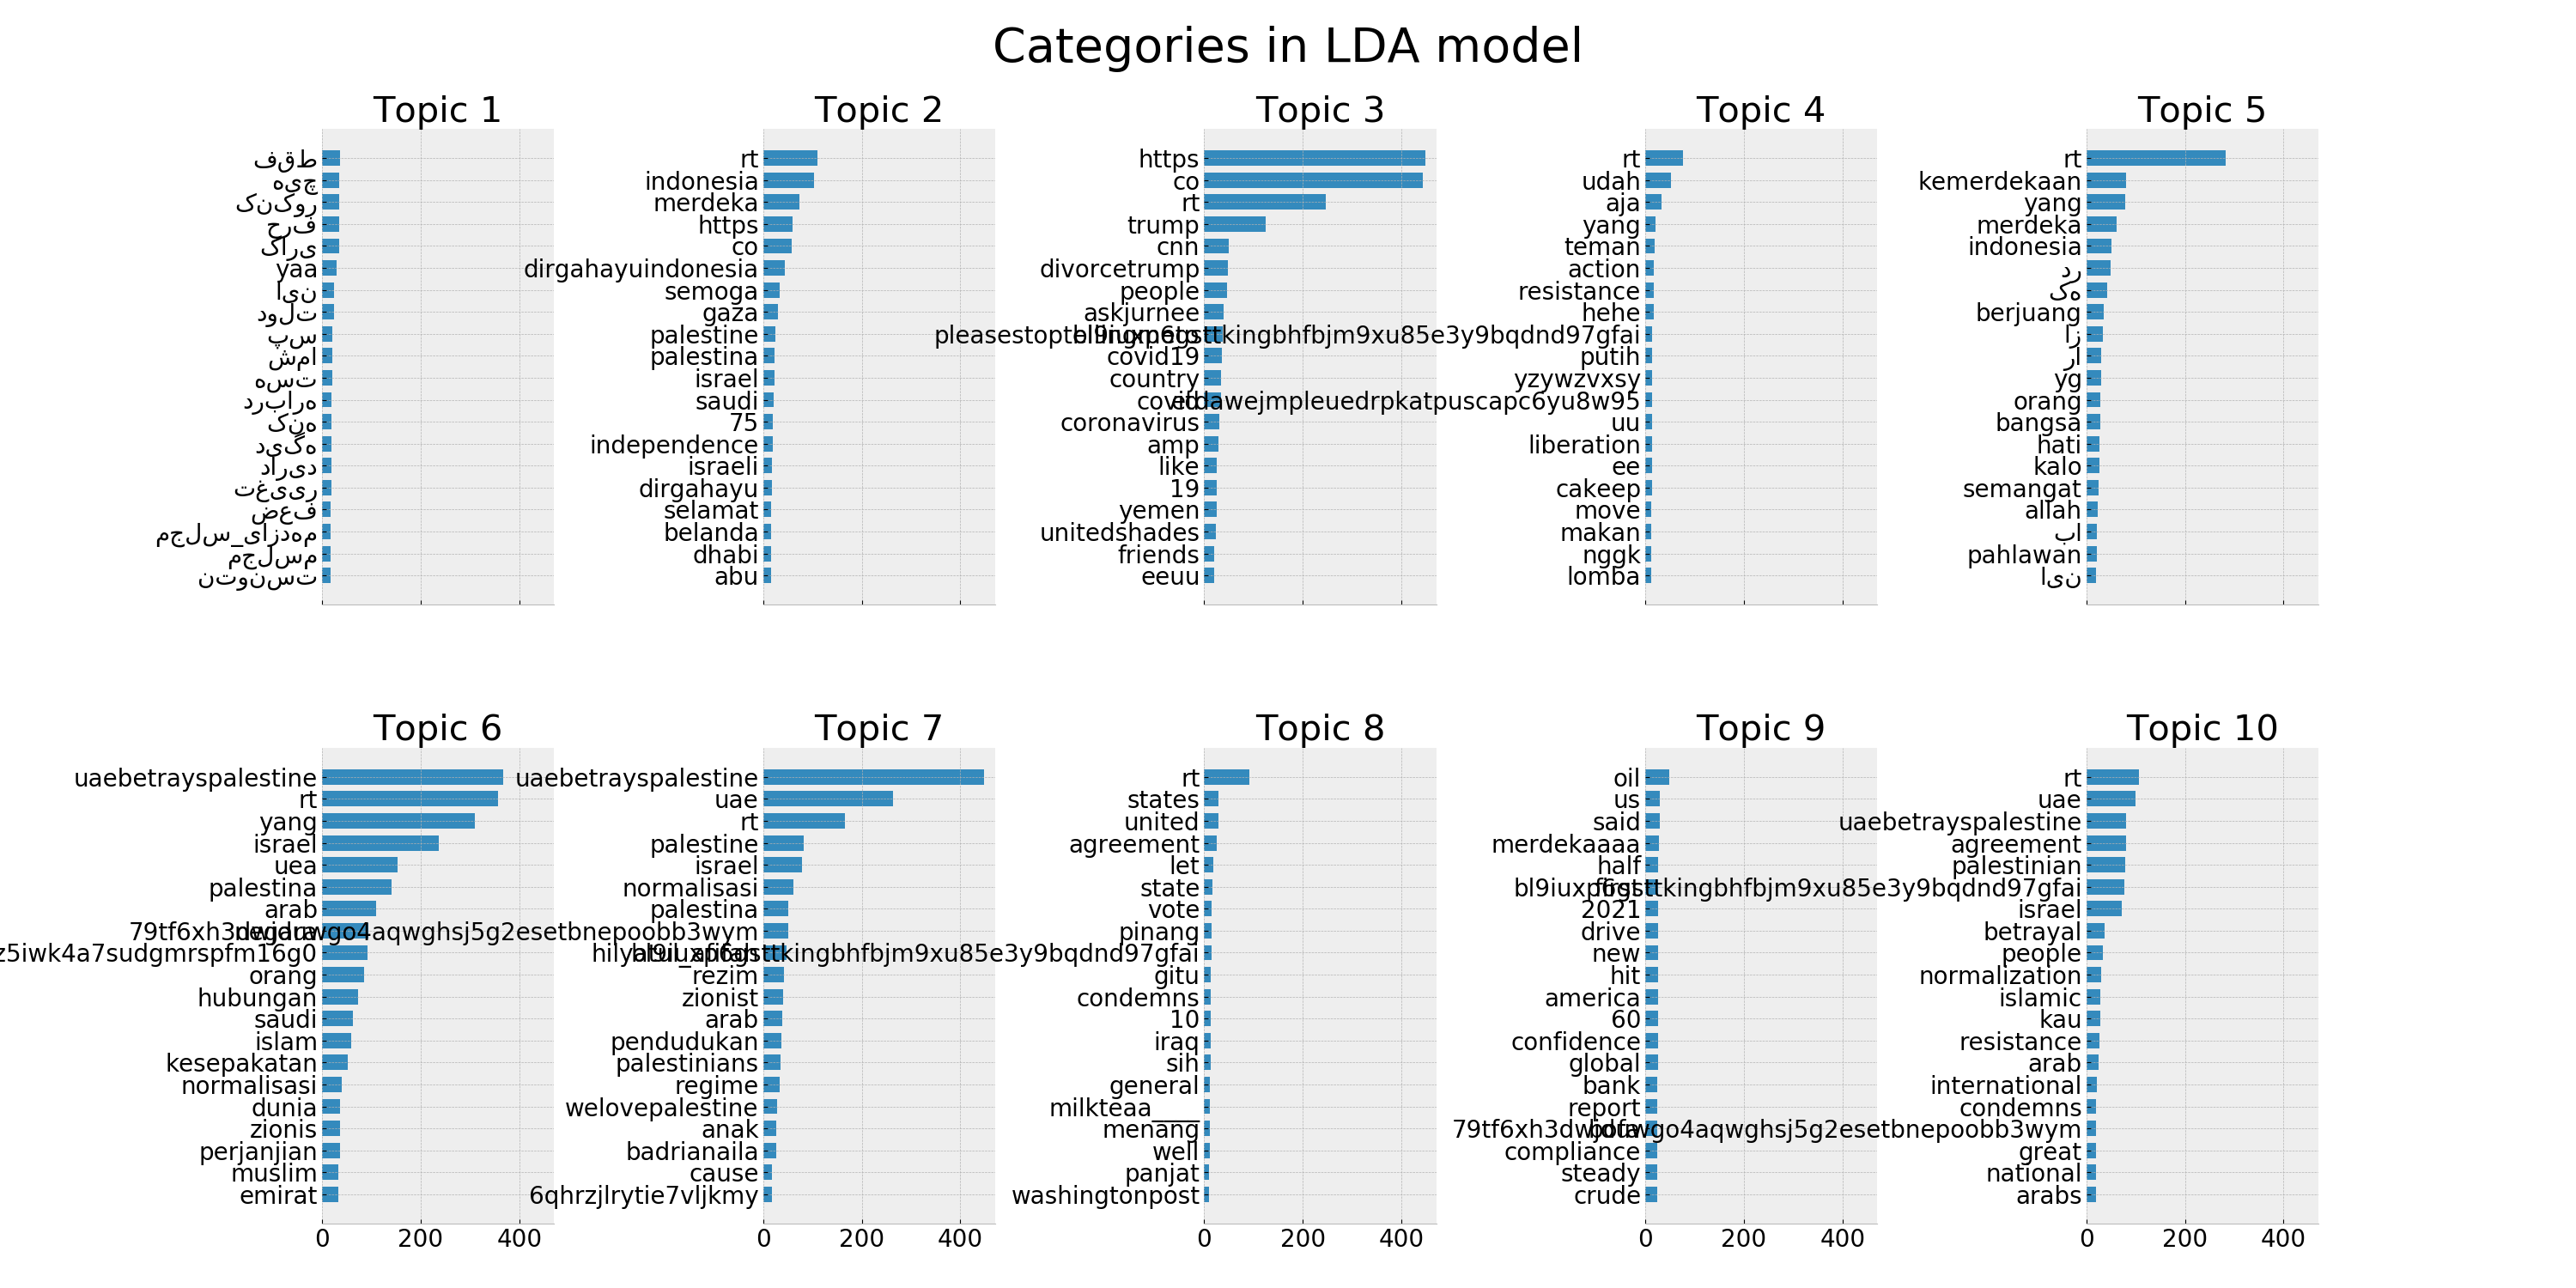

/home/sarah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


In [150]:
extract_topics(user_tweets)

We see that the top day was the day after Israel's foreign minister made a public declaration about military cooperation with the UAE, and the contents of the tweets are related to this event. Further analysis could potentially include applying sentiment analysis to these tweets and tweets in the surrounding time period to understand the sentiment towards this event, perhaps comparing campaign tweets with general tweets on the topic.